In [8]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

weekly = pd.read_csv(
    Path("../data/processed/weekly_sku_demand.csv"),
    parse_dates=["WeekStart"]
)

weekly = weekly.sort_values(["StockCode", "WeekStart"])
weekly.head()

,WeekStart,StockCode,weekly_units,weekly_revenue,n_orders,n_customers
0,2009-12-01,10002,143,121.55,11,11
1,2009-12-08,10002,59,51.85,6,4
2,2009-12-15,10002,12,10.20,1,1
3,2009-12-22,10002,2,2.55,2,1
4,2009-12-29,10002,3,2.55,1,1


In [2]:
def seasonal_naive_forecast(y, horizon=4, season_len=52):
    if len(y) >= season_len:
        base = y[-season_len]
    else:
        base = y[-1]
    return np.repeat(base, horizon)

In [3]:
def residual_std(y, season_len=52):
    errs = []
    for t in range(season_len, len(y)):
        pred = y[t-season_len]
        errs.append(y[t] - pred)
    return np.std(errs) if errs else np.std(y)

In [4]:
from scipy.stats import norm

horizon = 4
z = norm.ppf(0.95)  # 95% service level

sample_skus = weekly["StockCode"].drop_duplicates().head(20)

forecasts = []

for sku in sample_skus:
    sku_df = weekly[weekly["StockCode"] == sku].sort_values("WeekStart")
    y = sku_df["weekly_units"].to_numpy()

    if len(y) < 20:
        continue

    mu = seasonal_naive_forecast(y, horizon=horizon)
    sigma = residual_std(y)

    for h in range(horizon):
        forecasts.append({
            "StockCode": sku,
            "horizon_week": h + 1,
            "forecast_mean": mu[h],
            "forecast_std": sigma,
            "p95_demand": mu[h] + z * sigma
        })

fc = pd.DataFrame(forecasts)
fc.head()

,StockCode,horizon_week,forecast_mean,forecast_std,p95_demand
0,10002,1,12,21.000000,46.541926
1,10002,2,12,21.000000,46.541926
2,10002,3,12,21.000000,46.541926
3,10002,4,12,21.000000,46.541926
4,10120,1,12,22.264088,48.621165


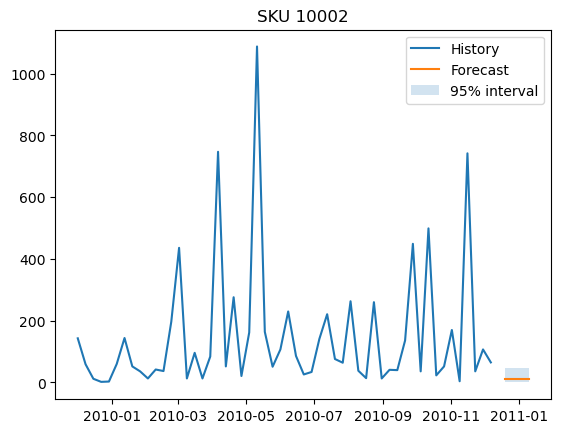

In [6]:
import matplotlib.pyplot as plt

sku = sample_skus.iloc[0]
sku_df = weekly[weekly["StockCode"] == sku].sort_values("WeekStart")

plt.figure()
plt.plot(sku_df["WeekStart"], sku_df["weekly_units"], label="History")

last_date = sku_df["WeekStart"].iloc[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(weeks=1),
    periods=horizon,
    freq="W-MON"
)

mu = seasonal_naive_forecast(sku_df["weekly_units"].to_numpy(), horizon)
sigma = residual_std(sku_df["weekly_units"].to_numpy())

lower = np.maximum(0, mu - z * sigma)
upper = mu + z * sigma

plt.plot(future_dates, mu, label="Forecast")
plt.fill_between(
    future_dates,
    lower,
    upper,
    alpha=0.2,
    label="95% interval"
)

plt.title(f"SKU {sku}")
plt.legend()
plt.show()

In [9]:
from src.inventory_logic import order_quantity

# Example: use the SKU you plotted
sku = "10002"

sku_df = weekly[weekly["StockCode"] == sku].sort_values("WeekStart")
y = sku_df["weekly_units"].to_numpy()

horizon = 8  # longer than max lead time slider
mu = seasonal_naive_forecast(y, horizon=horizon)
sigma = residual_std(y)

# Build mean forecast dict like {1:...,2:...}
forecast_mean_by_week = {i+1: float(mu[i]) for i in range(horizon)}

# Pretend current inventory (you'll make this an input later)
current_inventory = 50

# Try a couple lead times (this will be a slider later)
for lt in [2, 4, 6]:
    qty, rop, ss = order_quantity(
        current_inventory=current_inventory,
        forecast_mean_by_week=forecast_mean_by_week,
        forecast_std=sigma,
        lead_time_weeks=lt,
        service_level=0.95
    )
    print(f"Lead time={lt}w | ROP={rop:.1f} | SS={ss:.1f} | Order Qty={qty:.1f}")

Lead time=2w | ROP=72.9 | SS=48.9 | Order Qty=22.9
Lead time=4w | ROP=117.1 | SS=69.1 | Order Qty=67.1
Lead time=6w | ROP=156.6 | SS=84.6 | Order Qty=106.6
